# 3-2，中阶API示范

下面的范例使用TensorFlow的中阶API实现线性回归模型和和DNN二分类模型。

TensorFlow的中阶API主要包括各种模型层，损失函数，优化器，数据管道，特征列等等。

In [82]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

    

## 一、线性回归模型

### 1，准备数据

In [83]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers

In [84]:
#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


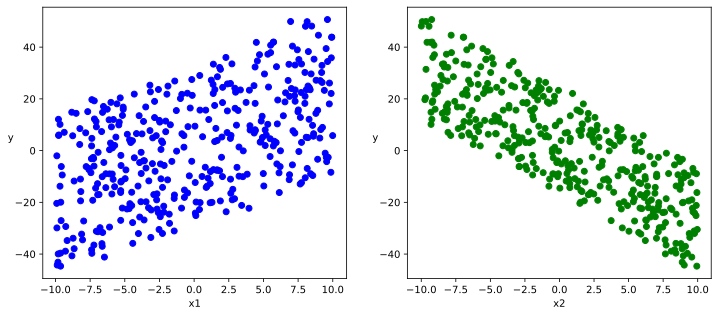

In [85]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [86]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(5) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

In [87]:
ds

<PrefetchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>

In [88]:
len(ds)

80

In [89]:
list(ds)

[(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
  array([[-1.2633114 , -0.05504799],
         [-3.8162017 ,  0.5424137 ],
         [ 5.51919   , -9.080708  ],
         [ 5.318882  , -8.178606  ],
         [-5.241306  ,  1.3651295 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
  array([[ -0.21686733],
         [ -8.862524  ],
         [ 40.74618   ],
         [ 37.25387   ],
         [-11.827513  ]], dtype=float32)>),
 (<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
  array([[ 2.0482998, -2.6546812],
         [ 4.9284077,  2.8585548],
         [-3.1523657, -8.823018 ],
         [-7.0718455, -6.9082975],
         [-4.0167546,  9.388168 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
  array([[ 18.556524 ],
         [  5.0689588],
         [ 22.707363 ],
         [ 11.23266  ],
         [-32.066917 ]], dtype=float32)>),
 (<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
  array([[-5.283675  ,  1.8504982 ],
         [ 0.12420654,  9.878784  

### 2，定义模型

In [90]:
model = layers.Dense(units = 1) 
model.build(input_shape = (2,)) #用build方法创建variables
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

### 3,训练模型

In [91]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=411.58896>

In [92]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])
train_model(model,epochs = 200)

================================================================================15:03:00
epoch = 50 loss =  9.0921278
w = [[2.00601125]
 [-3.01827335]]
b = [3.02141762]
================================================================================15:03:01
epoch = 100 loss =  4.70717907
w = [[1.98646653]
 [-2.96715498]]
b = [3.02254]
================================================================================15:03:03
epoch = 150 loss =  3.64203787
w = [[1.98306251]
 [-3.00831175]]
b = [3.02588725]
================================================================================15:03:04
epoch = 200 loss =  6.19407511
w = [[2.00516653]
 [-2.98016453]]
b = [3.02049565]


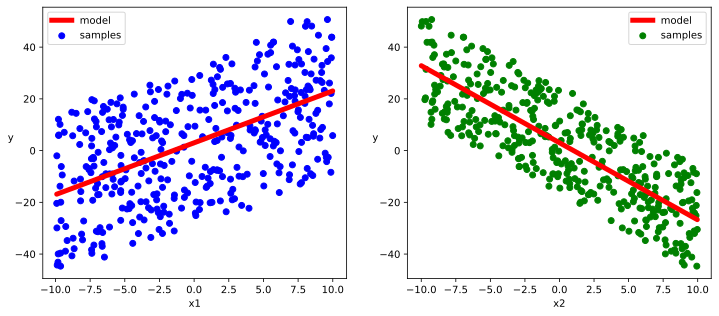

In [93]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

## 二、DNN二分类模型

### 1，准备数据

In [94]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

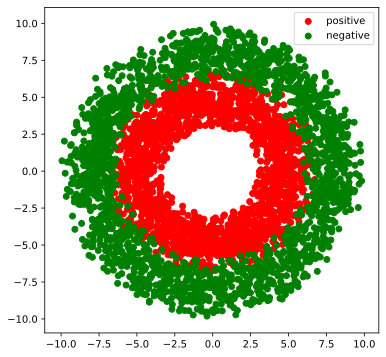

In [95]:
#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [96]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 4000).batch(100) \
     .prefetch(tf.data.experimental.AUTOTUNE) 

In [97]:
ds

<PrefetchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>

In [98]:
len(ds)

40

### 2，定义模型

In [99]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation = "relu") 
        self.dense2 = layers.Dense(8,activation = "relu")
        self.dense3 = layers.Dense(1,activation = "sigmoid")

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y
    
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [100]:
# 测试模型结构
(features,labels) = next(ds.as_numpy_iterator())

predictions = model(features)

loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:",loss)
tf.print("init metric",metric)


init loss: 0.925890565
init metric 0.54


### 3，训练模型

In [101]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric

# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.904674>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5>)

In [102]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model,epochs = 60)

================================================================================15:03:06
epoch = 10 loss =  0.598661125 accuracy =  0.66
================================================================================15:03:07
epoch = 20 loss =  0.479494631 accuracy =  0.8
================================================================================15:03:07
epoch = 30 loss =  0.275276035 accuracy =  0.94
================================================================================15:03:07
epoch = 40 loss =  0.160385251 accuracy =  0.95
================================================================================15:03:08
epoch = 50 loss =  0.130994096 accuracy =  0.95
================================================================================15:03:08
epoch = 60 loss =  0.101817936 accuracy =  0.97


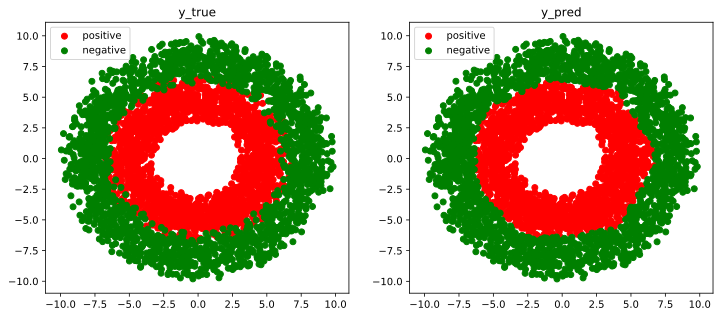

In [103]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");